In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

### Metropolitan area

##### Clean data

In [48]:
df = pd.read_csv(r'../data/df_allmetro_all.csv')
# allgemeines unemployment nehmen 

# country column
df['country'] = df['metroreg'].apply (lambda x: x[:2])

# calculate relative crime
df.loc[:, 'crime/population'] = (df['Nr_Crimes'] / df['population']) *1_000_000     # normalizing to per Million 
df.loc[:, 'density'] = df['population'] / df['area'] 
# df.loc[:, 'crime/density'] = df['Nr_Crimes'] / df['density']

# drop na
df.dropna()

# log columns
df.loc[:, 'crime/population_log'] = np.log(df['crime/population'] + 1e-20)  # add small number to avoid log(0)
df.loc[:, 'density_log'] = np.log(df['density'] + 1e-20)
# df.loc[:, 'crime/density_log'] = np.log(df['crime/density'] + 1e-20)
df.loc[:, 'unemp_log'] = np.log(df['unemp per Tsd.'] + 1e-20)   # unemployment per tsd.
df.loc[:, 'gdp_log'] = np.log(df['gdp'] + 1e-20)        # kaufkraftbereinigten gdp nehmen

# drop aggregates
df = df[df['metroreg'].str.len() >= 3]

# choosing youth unemployment & normalized PP standard 
df = df[(df['unit'] == 'PPS_HAB_EU27_2020:Purchasing power standard (PPS, EU27 from 2020), per inhabitant in percentage of the EU27 (from 2020) average')  & (df['dfunemp_sex'] == 'T:Total')]

df.to_csv(r'../data/normalized_data.csv')

In [4]:
# select year
def select_year(df, year):
    df = df[df['TIME_PERIOD'] == year]
    return df

# group by type of crime
def group_by_iccs(df):
    df = df.groupby(['metroreg', 'iccs_d']).first().reset_index()   
    return df

# plot scatterplot, correlations
def plot_scatterplot(df, x, y):
    for crime_type in df['iccs_d'].unique():
        subset = df[df['iccs_d'] == crime_type]
        plot = sns.scatterplot(x=x, y=y, data=subset)
        m,b = np.polyfit(subset[x], subset[y], 1)
        plot.plot(subset[x], m*subset[x] + b, color = 'red')
        plt.show()
        print(f'Correlation for {crime_type}:\n {subset[[x, y]].corr()}')




In [5]:
df = df.dropna(subset=['unemp_log'])

In [6]:
# select year
df_year = select_year(df, 2019)

# group by type of crime
df_year_grouped = group_by_iccs(df_year)

# plot scatterplot, correlations
# plot_scatterplot(df_year_grouped, 'density_log', 'crime/population_log')
# plot_scatterplot(df_year_grouped, 'unemp per Tsd.', 'crime/density_log')

In [7]:
df_year_grouped.head()

,metroreg,iccs_d,TIME_PERIOD,unit,gdp,area,population,dfunemp_sex,dfunemp_age,unemp per Tsd.,...,metroreg_d,metroreg_type,crime/population,density,crime/density,crime/population_log,density_log,crime/density_log,unemp_log,gdp_log
0,AT001MC,Burglary of private residential premises,2019,EUR_HAB:Euro per inhabitant,47800.0,8817.0,2853903.0,M:Males,Y15-24:From 15 to 24 years,11.4,...,Wien,M,0.001697,323.681865,14.962222,-6.378908,5.779761,2.705529,2.433613,10.774781
1,AT001MC,Intentional homicide,2019,EUR_HAB:Euro per inhabitant,47800.0,8817.0,2853903.0,M:Males,Y15-24:From 15 to 24 years,11.4,...,Wien,M,0.000011,323.681865,0.098863,-11.398462,5.779761,-2.314025,2.433613,10.774781
2,AT001MC,Robbery,2019,EUR_HAB:Euro per inhabitant,47800.0,8817.0,2853903.0,M:Males,Y15-24:From 15 to 24 years,11.4,...,Wien,M,0.000563,323.681865,4.964751,-7.482074,5.779761,1.602363,2.433613,10.774781
3,AT001MC,Theft of a motorized land vehicle,2019,EUR_HAB:Euro per inhabitant,47800.0,8817.0,2853903.0,M:Males,Y15-24:From 15 to 24 years,11.4,...,Wien,M,0.000152,323.681865,1.337733,-8.793460,5.779761,0.290977,2.433613,10.774781
4,AT002M,Burglary of private residential premises,2019,EUR_HAB:Euro per inhabitant,45700.0,3479.0,637532.0,M:Males,Y15-74:From 15 to 74 years,6.0,...,Graz,M,0.001001,183.251509,3.481554,-6.907021,5.210860,1.247479,1.791759,10.729854


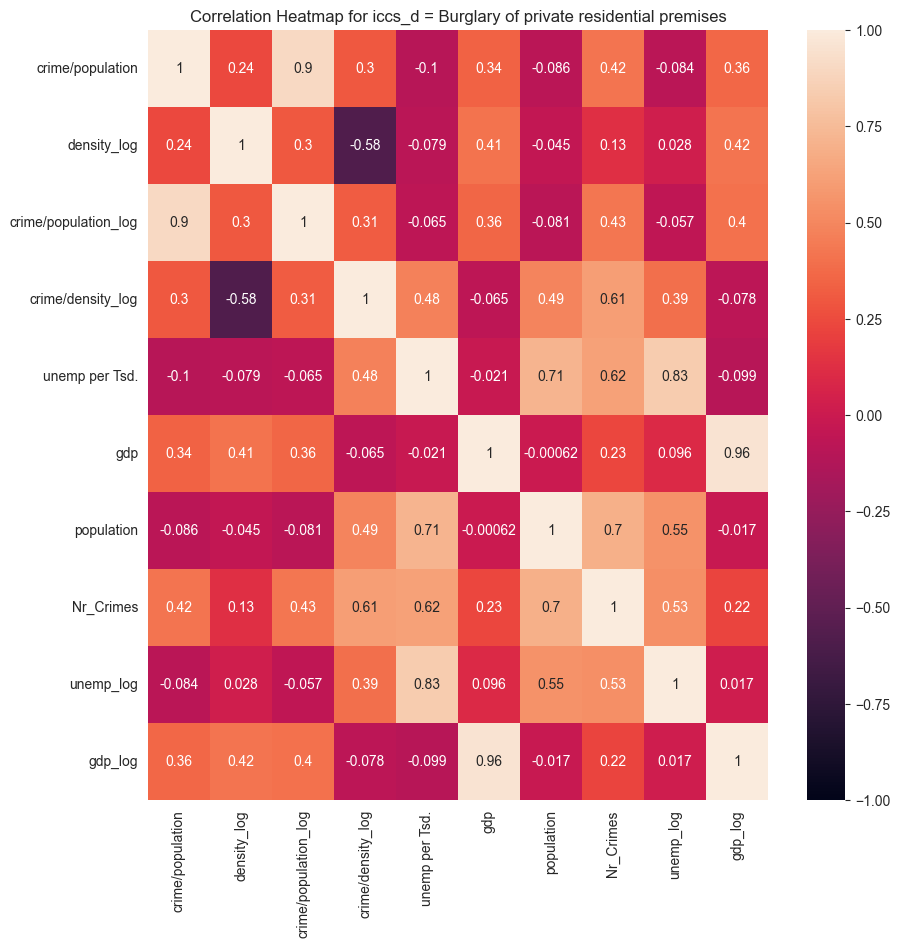

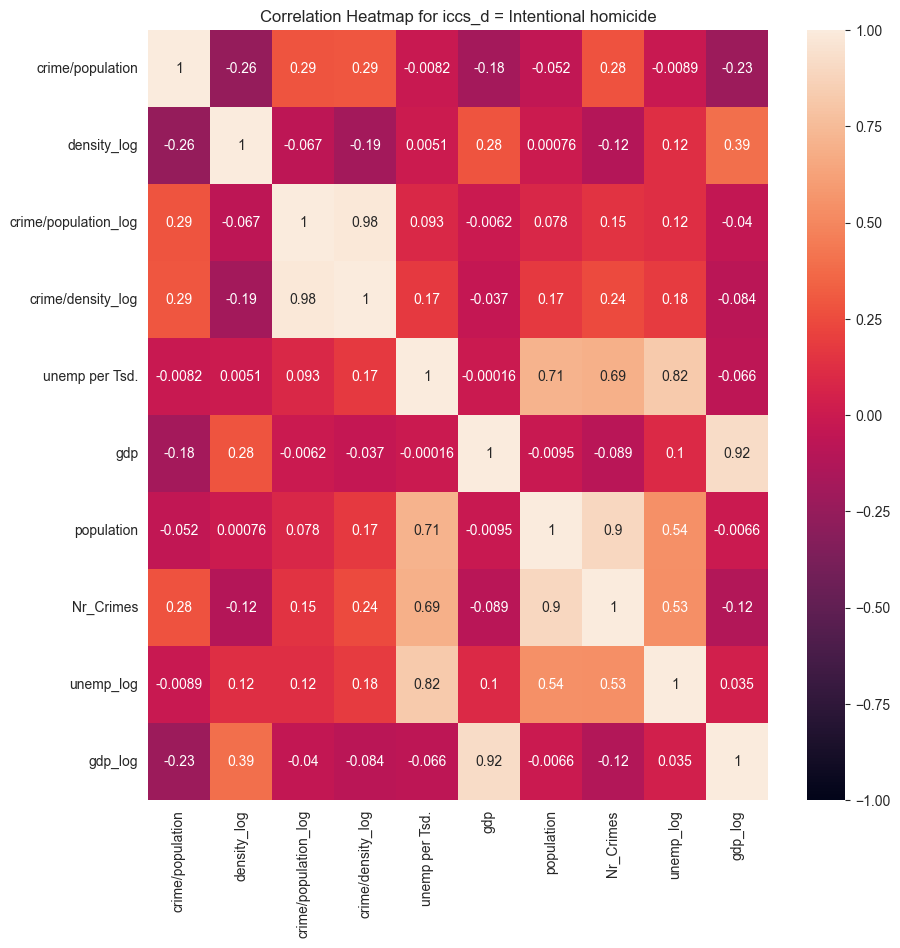

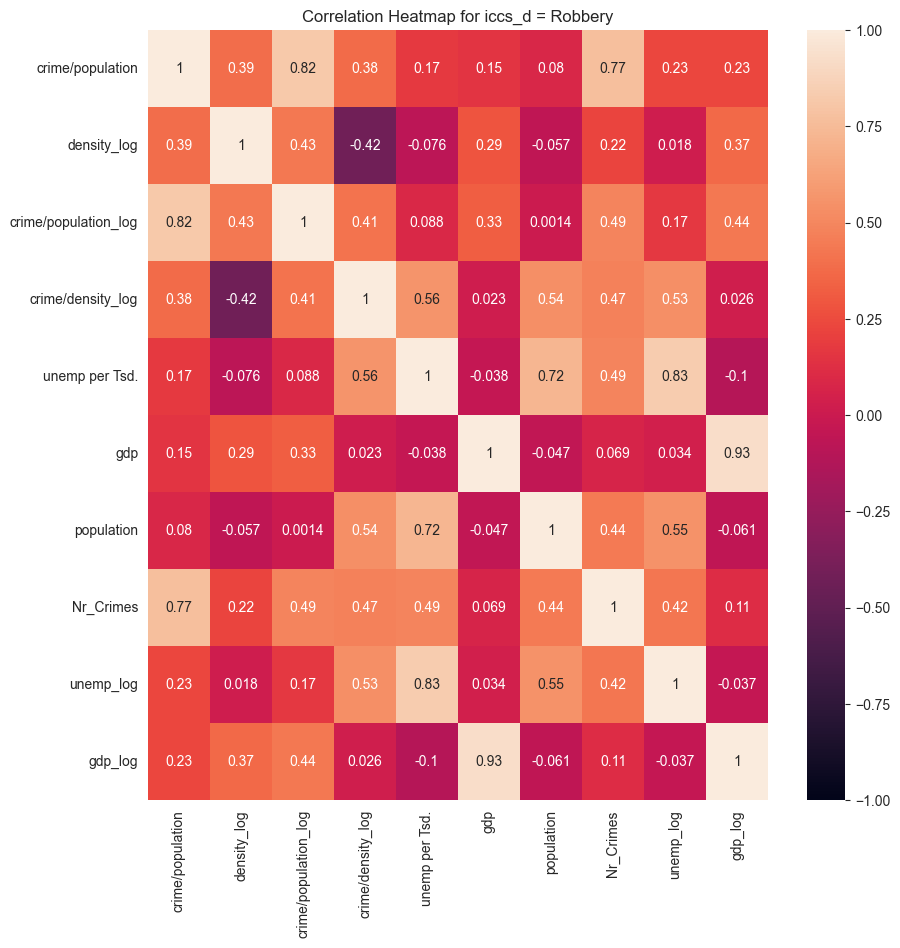

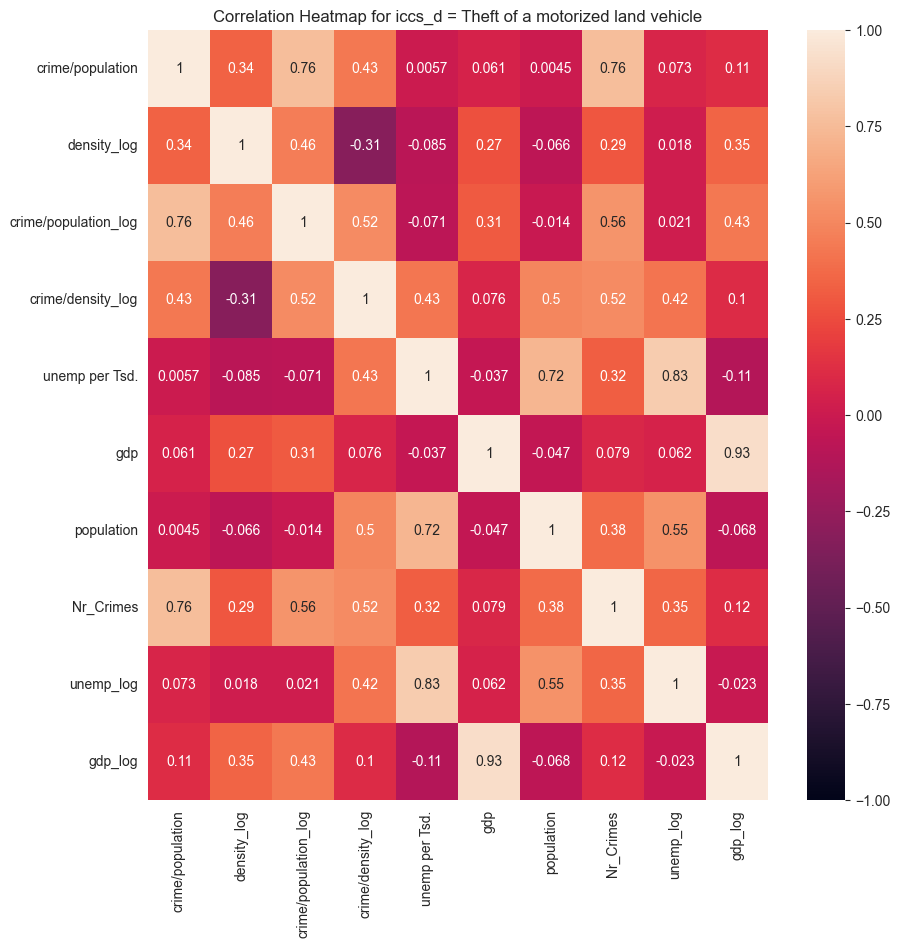

In [8]:
# Loop over the unique 'iccs_d' values in the DataFrame
for iccs in df_year_grouped['iccs_d'].unique():
    # Create a subset of the DataFrame that only contains the rows with the current 'iccs_d' value
    subset = df_year_grouped[df_year_grouped['iccs_d'] == iccs]

    # Calculate the correlation matrix for the subset
    corr = subset[['crime/population', 'density_log', 'crime/population_log',  'crime/density_log', 'unemp per Tsd.', 'gdp', 'population', 'Nr_Crimes', 'unemp_log', 'gdp_log']].corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr, annot=True, vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for iccs_d = {iccs}')
    plt.show()

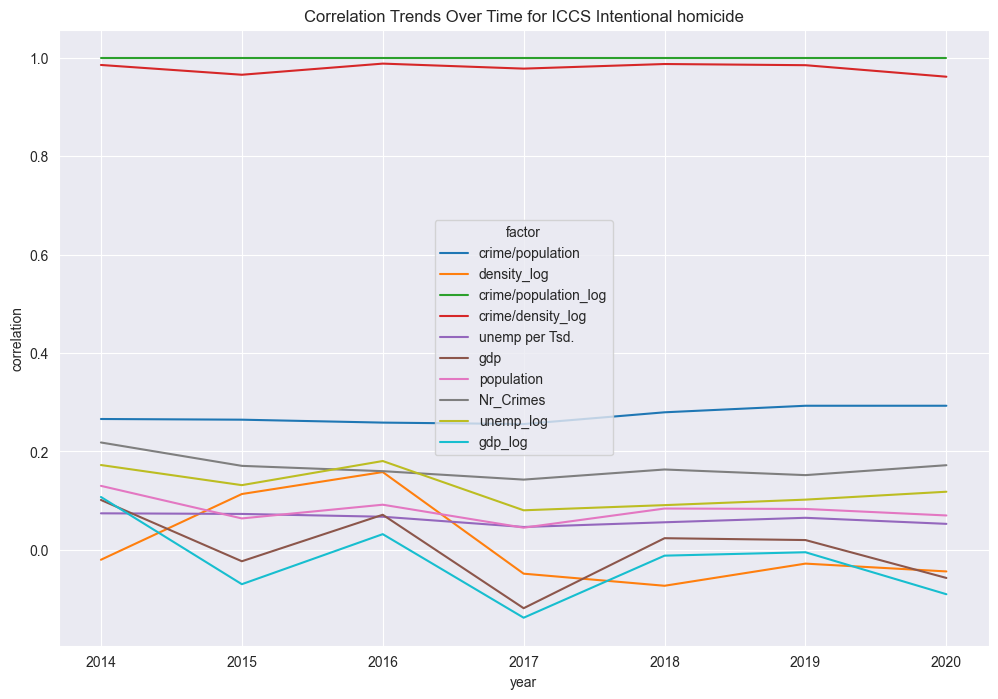

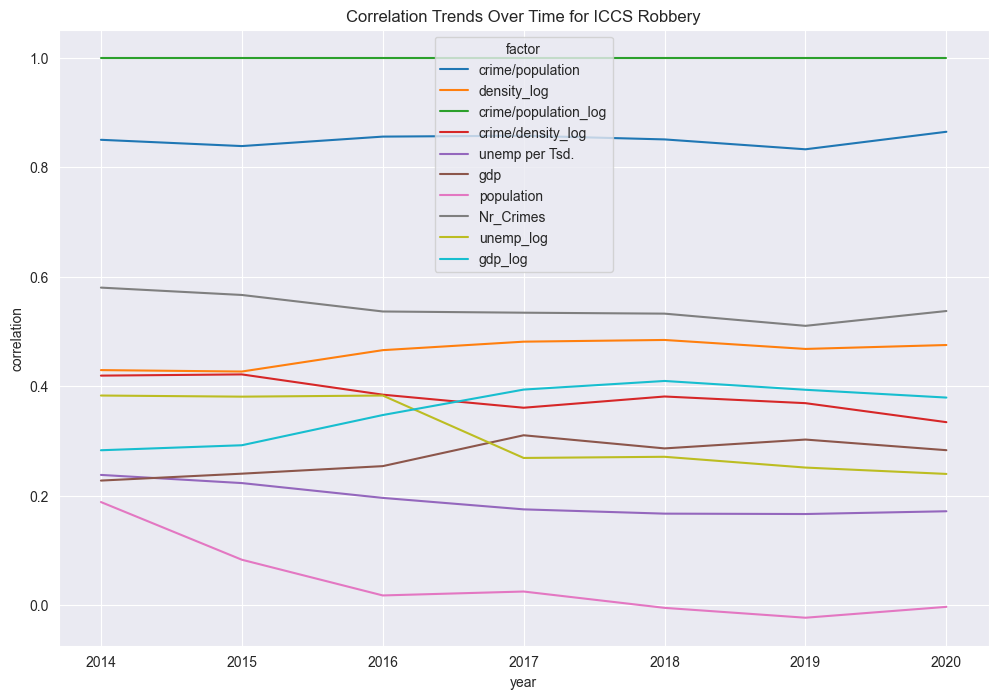

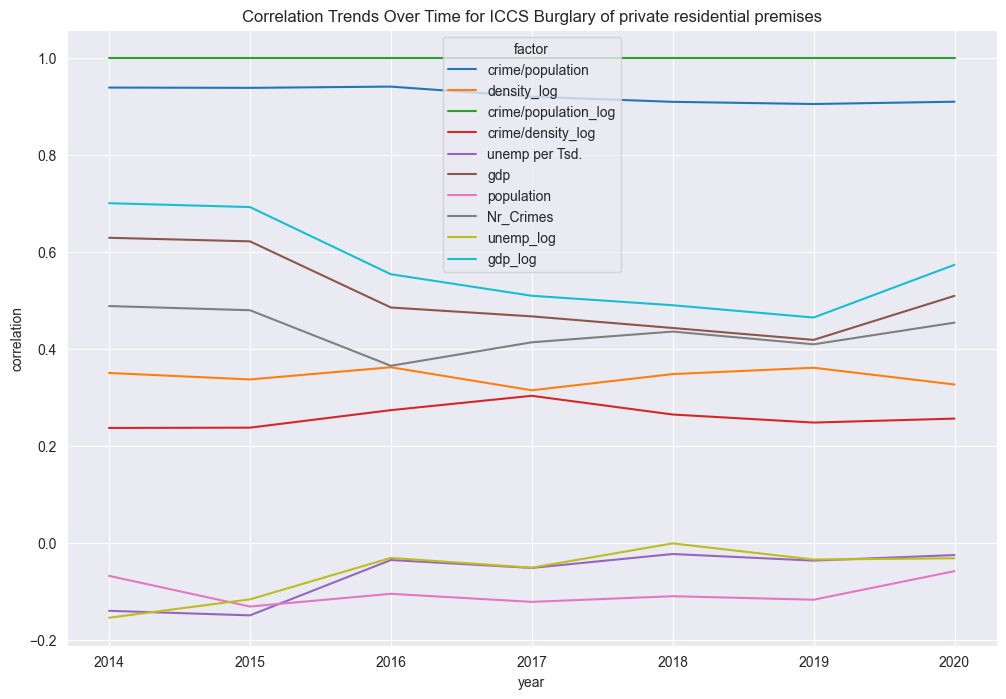

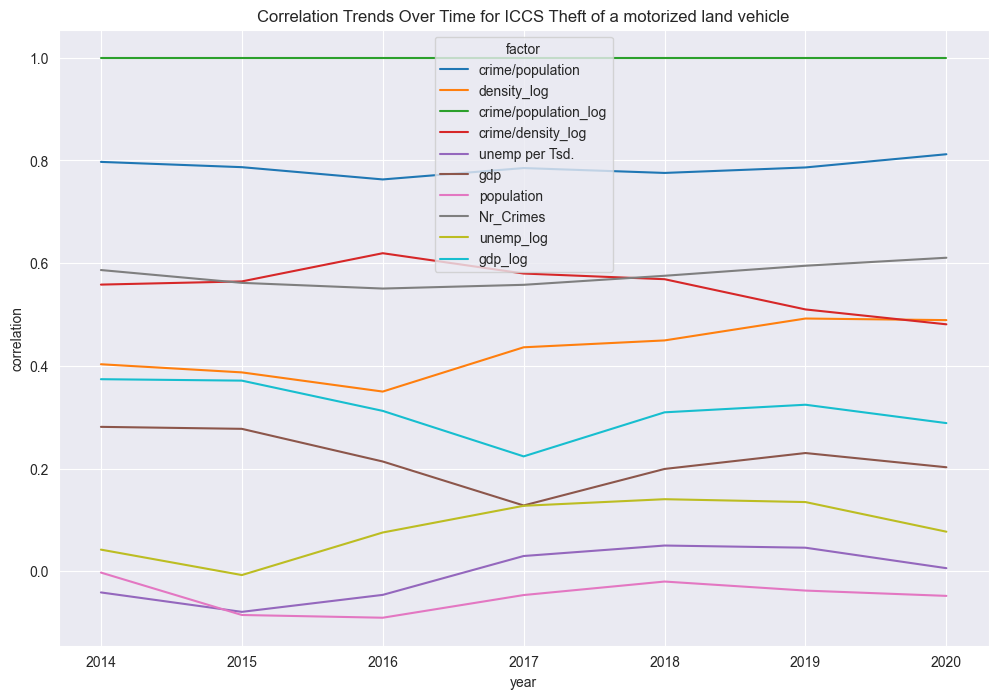

In [9]:
# testing stabilty of correlations over the years

for iccs_value in df['iccs_d'].unique():
    correlation_data = []

    for year in df['TIME_PERIOD'].unique():
        df_year = df[df['TIME_PERIOD'] == year]
        # Create a subset of the DataFrame that only contains the rows with the current 'iccs_d' value
        subset = df_year[df_year['iccs_d'] == iccs_value]
        # Calculate the correlation matrix for the subset
        corr = subset[['crime/population', 'density_log', 'crime/population_log',  
                       'crime/density_log', 'unemp per Tsd.', 'gdp', 'population',
                       'Nr_Crimes', 'unemp_log', 'gdp_log']].corr()
        
        # Iterate over the columns of the correlation matrix
        for factor in corr.columns:
            correlation_data.append({
                'year': year,
                'iccs': iccs_value,
                'factor': factor,
                'correlation': corr.loc[factor, 'crime/population_log']     # target variable
            })

    # Create a DataFrame from the collected correlation data
    correlation_df = pd.DataFrame(correlation_data)

    # Plot using seaborn
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='year', y='correlation', hue='factor', data=correlation_df)
    plt.title(f'Correlation Trends Over Time for ICCS {iccs_value}')
    plt.show()

In [10]:
# regression model using k fold
def regression_model(df, x, y):
    # Reset the index of the DataFrame
    df = df.reset_index(drop=True)
    
    # Split data
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(df)
    
    # Create model
    coefficients = []
    r2_scores = []
    model = LinearRegression()
    
    # Train model
    for train_index, test_index in kf.split(df):
        X_train, X_test = df.iloc[train_index][x], df.iloc[test_index][x]
        y_train, y_test = df.iloc[train_index][y], df.iloc[test_index][y]
        
        model.fit(X_train, y_train)
        
        coefficients.append(model.coef_)
        r2_scores.append(model.score(X_test, y_test))
    
    # Return the trained model
    return np.mean(coefficients), np.mean(r2_scores)

In [11]:
for iccs in df_year_grouped['iccs_d'].unique():
    subset = df_year_grouped[df_year_grouped['iccs_d'] == iccs]
    mean_r2 = regression_model(subset, ['density_log', 'unemp_log', 'gdp_log'], ['crime/population_log'])
    print("{:-^50}".format(iccs))
    print(f"Mean R2: {mean_r2[1]}", sep='\n')

-----Burglary of private residential premises-----
Mean R2: 0.11687254771921127
---------------Intentional homicide---------------
Mean R2: -1.3902760016373379
---------------------Robbery----------------------
Mean R2: 0.23098994740250928
--------Theft of a motorized land vehicle---------
Mean R2: 0.18603615325637968
